In [5]:
#載入執行程式所需套件
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding,Flatten,Conv1D,MaxPooling1D,BatchNormalization,GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gc
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score

In [6]:
#讀取檔案，將檔案名稱設為train
train = pd.read_csv("/kaggle/input/predict-student-performance-from-game-play/train.csv",
                usecols=['session_id','elapsed_time','level_group'])#選出影響學生玩遊戲表現 session_id是固定欄位
print(train.shape)
train.head()#前五比資料

(26296946, 3)


,session_id,elapsed_time,level_group
0,20090312431273200,0,0-4
1,20090312431273200,1323,0-4
2,20090312431273200,831,0-4
3,20090312431273200,1147,0-4
4,20090312431273200,1863,0-4


In [7]:
#讀取檔案，將檔案名稱設為target
target = pd.read_csv("/kaggle/input/predict-student-performance-from-game-play/train_labels.csv")
tmp = target.session_id.str.split("_", expand =True)
target["user_id"] = tmp[0].astype("int")
target["q"] = tmp[1].str.slice(1).astype("int")
print(target.shape)
target.head()

(424116, 4)


,session_id,correct,user_id,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


In [8]:
train.session_id.nunique(), target.user_id.nunique()

(23562, 23562)

In [9]:
#分割目標長度
GP1 = '0-4'
GP2 = '5-12'
GP3 = '13-22'

GROUP_DATA = {
    GP1: {
        "data": [],
        'target': target[(target.q >= 1) & (target.q <= 3)] 
    },
    GP2: {
        "data": [],
        'target': target[(target.q >= 4) & (target.q <= 13)]
    },
    GP3: {
        "data":  [],
        'target': target[(target.q >= 14) & (target.q <= 18)]
    }
}


grp=[GP1,GP2,GP3]
def feature_engineer(df):
    df = df.loc[:,['session_id','elapsed_time','level_group']]
    df.elapsed_time /= 1000 #轉為秒
    event_duration = df.elapsed_time.diff().fillna(0).clip(0,3600).astype("float32") #3600秒一小時
    df['event_duration'] = event_duration.astype("float32")
    df.drop('elapsed_time', axis = 1, inplace =True)
    
    for level in grp:
        GROUP_DATA[level]["data"] = df[df["level_group"] ==level]
        
    for level in grp:
        tmp = []
        user_id = []
        for session_id, info in GROUP_DATA[level]["data"].groupby("session_id"):
            tmp.append(info['event_duration'].astype("float32"))
            user_id.append(session_id)
        GROUP_DATA[level]["data"] = pad_sequences(tmp, padding='post', maxlen = 500,dtype='float16')
    return df

In [10]:
feature_engineer(train)

,session_id,level_group,event_duration
0,20090312431273200,0-4,0.000
1,20090312431273200,0-4,1.323
2,20090312431273200,0-4,0.000
3,20090312431273200,0-4,0.316
4,20090312431273200,0-4,0.716
...,...,...,...
26296941,22100221145014656,13-22,1.046
26296942,22100221145014656,13-22,1.935
26296943,22100221145014656,13-22,0.751
26296944,22100221145014656,13-22,0.836


In [11]:
_ = gc.collect()

In [12]:
for level in grp:
    print(GROUP_DATA[level]["data"].shape, GROUP_DATA[level]["target"].user_id.nunique())

(23562, 500) 23562
(23562, 500) 23562
(23562, 500) 23562


In [13]:
GROUP_DATA[GP1]["data"][0][:5]

array([0.   , 1.323, 0.   , 0.316, 0.716], dtype=float16)

In [14]:
GROUP_DATA[GP1]["target"].head(2)

,session_id,correct,user_id,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1


In [15]:
_ = gc.collect()

In [16]:
def train_model(dim): 
    model = Sequential()
    model.add(Embedding(input_dim=dim, output_dim=128, input_length=500))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
#     model.add(MaxPooling1D(pool_size=3))
#     model.add(Conv1D(filters = 32, kernel_size=3,activation="relu"))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [17]:
train_model(100).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          12800     
                                                                 
 conv1d (Conv1D)             (None, 498, 32)           12320     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [18]:
ALL_USER = train.session_id.unique()
len(ALL_USER)

23562

In [19]:
pred_df = pd.DataFrame(np.zeros((len(ALL_USER),18)), index= ALL_USER,columns=range(1,19))
pred_df.head(3)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
20090312431273200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20090312433251036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20090312455206810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# keep_model = {}
ques_grp = {GP1:(1,4),GP2:(4,14),GP3:(14,19)}
# save_history = []

# tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)
for level in grp:
    a, b = ques_grp[level]
    for Q in range(a,b):
        model = train_model(int(GROUP_DATA[level]["data"].max())+1 #最大的數字要再+1曾能送到embedding因為embedding會試左閉又開，不包含傳入的.max()值
                        )
        model.compile(loss="binary_crossentropy", optimizer = "adam",metrics = "accuracy")
        grp_target = GROUP_DATA[level]["target"]
        y_label = grp_target[grp_target.q == Q].correct
        
        
        model_checkpoint_callback = ModelCheckpoint(
                                    filepath=f'{level}_{Q}/checkpoint',
                                    save_weights_only= False,
                                    monitor='val_accuracy',
                                    mode='max',
                                    save_best_only=True)
        
        print(f"NUM: {Q}")
        History = model.fit(GROUP_DATA[level]["data"],
                            y_label,validation_split=0.1, 
                            epochs=3, 
                            batch_size= 256,
                            verbose = 1,
                            callbacks = [model_checkpoint_callback])
#         save_history.append(History)
        loss, acc = model.evaluate(GROUP_DATA[level]["data"],
                                   y_label)
        y_pred = model.predict(GROUP_DATA[level]["data"])
#         keep_model[f"{level}_{Q}"] = model
        pred_df[Q] = y_pred

NUM: 1
Epoch 1/3
83/83 [==============================] - 14s 87ms/step - loss: 0.6000 - accuracy: 0.7220 - val_loss: 0.5757 - val_accuracy: 0.7365
Epoch 2/3
83/83 [==============================] - 2s 26ms/step - loss: 0.5842 - accuracy: 0.7265 - val_loss: 0.5658 - val_accuracy: 0.7365
Epoch 3/3
737/737 [==============================] - 1s 2ms/step
NUM: 2
Epoch 1/3
83/83 [==============================] - 6s 58ms/step - loss: 0.2418 - accuracy: 0.9597 - val_loss: 0.1054 - val_accuracy: 0.9784
Epoch 2/3
83/83 [==============================] - 2s 21ms/step - loss: 0.1062 - accuracy: 0.9789 - val_loss: 0.1054 - val_accuracy: 0.9784
Epoch 3/3
737/737 [==============================] - 1s 2ms/step
NUM: 3
Epoch 1/3
83/83 [==============================] - 6s 57ms/step - loss: 0.3103 - accuracy: 0.9322 - val_loss: 0.2267 - val_accuracy: 0.9406
Epoch 2/3
83/83 [==============================] - 1s 16ms/step - loss: 0.2498 - accuracy: 0.9333 - val_loss: 0.2261 - val_accuracy: 0.9406
Epoch 3/

In [21]:
_ = gc.collect()

In [22]:
_ = gc.collect()

In [23]:
pred_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
20090312431273200,0.788851,0.982208,0.952859,0.819844,0.643657,0.782769,0.760743,0.661631,0.765675,0.563286,0.709199,0.872609,0.336516,0.660461,0.480991,0.763474,0.754790,0.951606
20090312433251036,0.828043,0.980199,0.955798,0.861506,0.541423,0.753781,0.747230,0.608003,0.693766,0.489616,0.629537,0.876346,0.227965,0.677202,0.401926,0.778341,0.602889,0.948709
20090312455206810,0.743552,0.974954,0.939155,0.773964,0.607163,0.743329,0.715399,0.636693,0.728056,0.523609,0.633492,0.864993,0.332226,0.697066,0.426276,0.740222,0.704363,0.954050
20090313091715820,0.691020,0.979678,0.943060,0.807793,0.607352,0.767283,0.730826,0.647062,0.721690,0.511756,0.673303,0.877594,0.217769,0.668985,0.509174,0.741137,0.707082,0.952940
20090313571836404,0.846526,0.982420,0.953614,0.829110,0.676678,0.803767,0.764928,0.641424,0.781585,0.597994,0.712179,0.879048,0.323963,0.718697,0.633359,0.736854,0.761298,0.954013


In [24]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true =pred_df.copy()
for Q in range(1,19):
    # GET TRUE LABELS
    tmp = target.loc[target.q == Q].set_index('user_id').loc[ALL_USER]
    true[Q] = tmp.correct.values
true.head(3)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
20090312431273200,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1
20090312433251036,0,1,1,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1
20090312455206810,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1


In [25]:
scores = []
thresholds = []
best_score = 0
best_threshold = 0
#values: Only the values in the DataFrame will be returned, the axes labels will be removed.
#reshape(-1): 降至一維
for t in np.arange(0.4,0.8, 0.01):
    pred = (pred_df.values.reshape(-1) > t).astype("int")
    s = f1_score(true.values.reshape(-1), pred,average='macro')
    scores.append(s)
    thresholds.append(t)
best_score = max(scores)
best_threshold = thresholds[scores.index(max(scores))]

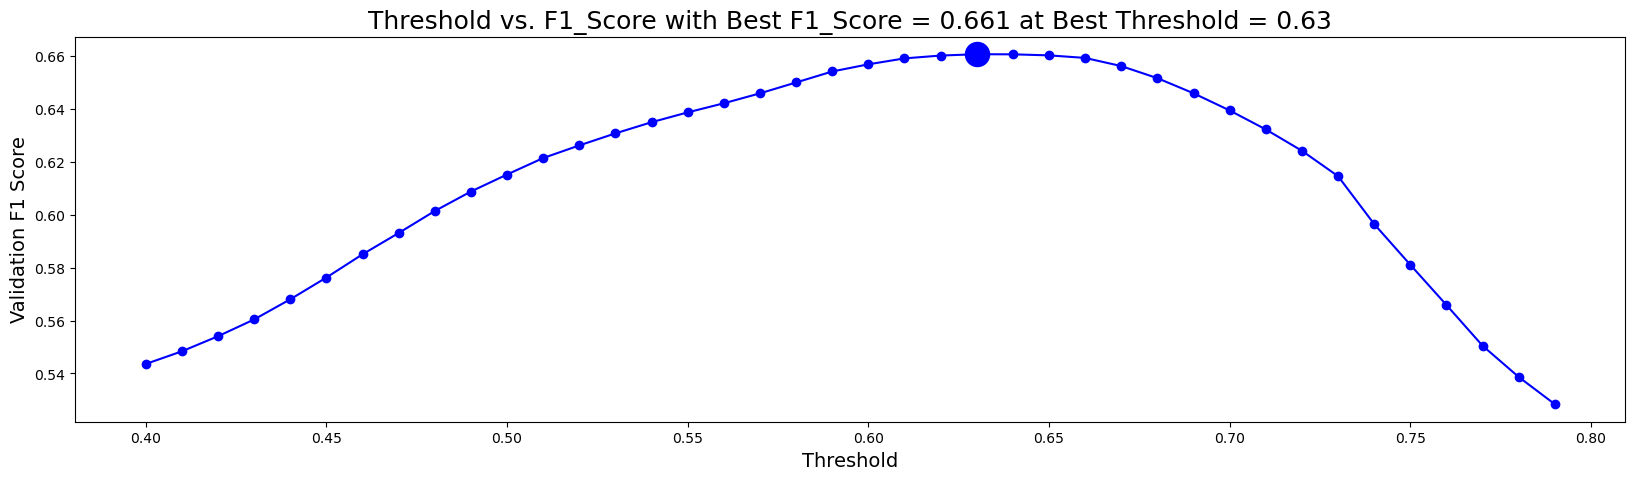

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter(best_threshold, best_score, color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [27]:
for i in range(1,19):
    pred = (pred_df[i].values.reshape(-1) > best_threshold).astype("int")
    s = f1_score(true[i].values.reshape(-1), pred,average='macro')
    print(f"Q{i} F1_score: {s}")

pred = (pred_df.values.reshape(-1) > best_threshold).astype("int")
s = f1_score(true.values.reshape(-1), pred,average='macro')
print(f"OVERALL F1_score: {s}")

Q1 F1_score: 0.5928692616697382
Q2 F1_score: 0.49464879356568364
Q3 F1_score: 0.4829379622111523
Q4 F1_score: 0.44449477187690567
Q5 F1_score: 0.45039950721075117
Q6 F1_score: 0.43706783565379376
Q7 F1_score: 0.42882210853409913
Q8 F1_score: 0.5151158734514214
Q9 F1_score: 0.4241958555178726
Q10 F1_score: 0.3365534923622443
Q11 F1_score: 0.5563473630967659
Q12 F1_score: 0.46321904544936776
Q13 F1_score: 0.42025490871512233
Q14 F1_score: 0.4233889226337349
Q15 F1_score: 0.43613275168160454
Q16 F1_score: 0.4235737351991388
Q17 F1_score: 0.5066889933200094
Q18 F1_score: 0.48734796893017995
OVERALL F1_score: 0.6606554152616033


In [28]:
# IMPORT KAGGLE API
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

In [29]:
def test_engineer(level, df):
    df = df.loc[:,['session_id','elapsed_time','level_group']]
    df.elapsed_time /= 1000 #轉為秒
    event_duration = df.elapsed_time.diff().fillna(0).clip(0,3600)#最大道3600秒也就是一小時
    df['event_duration'] = event_duration.astype("float32")
    df.drop('elapsed_time', axis = 1, inplace =True)

    GROUP_DATA[level]["data"] = df
        
    tmp = []
    for session_id, info in GROUP_DATA[level]["data"].groupby("session_id"):
        tmp.append(info['event_duration'])
    GROUP_DATA[level]["data"] = pad_sequences(tmp, padding='post', maxlen = 500,dtype='float16')

In [30]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for i, (test, sample_submission) in enumerate(iter_test): #第一次0-4 最後一次是13-22
    level = test.level_group.values[0]
    test_engineer(level, test)
    # INFER TEST DATA    
    a,b = limits[level]
    for Q in range(a,b):
        model = load_model(f'{level}_{Q}/checkpoint')
        pred_value = model.predict(GROUP_DATA[level]["data"])
        
        mask = sample_submission.session_id.str.contains(f'q{Q}')
        sample_submission.loc[mask,'correct'] = ( pred_value > best_threshold ).astype("int")
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
1/1 [==============================] - 0s 66ms/step


In [31]:
pd.read_csv("/kaggle/working/submission.csv")

,session_id,correct
0,20090109393214576_q1,1
1,20090312143683264_q1,1
2,20090312331414616_q1,1
3,20090109393214576_q2,1
4,20090312143683264_q2,1
5,20090312331414616_q2,1
6,20090109393214576_q3,1
7,20090312143683264_q3,1
8,20090312331414616_q3,1
9,20090109393214576_q4,1


會選擇這一個主題參選是因為這個題目很有趣所以決定試試看，在實作上面遇到很多困難也不太知道怎麼解決，所以在程式碼上大多都是和我身為AI系的親戚一起打出來的，前前後後花了很多時間跟精力在問她問題，雖然結果沒有到很完整，也有別的想嘗試的想法，我們認為也可以使用其他線性函數的方法來處理。這份方程式是從玩遊戲預測學生的表現，實驗結果是遊戲是會影響表現的。而這份作業中的圖表是從大一微積分中的Python加分作業中學到的，要先import模組才有辦法生成，還有其他x,y軸等數值才有辦法完成。分割目標長度也是上學期修python課的時候習得的知識，其他預測的練習是從上課講義中改正得到的，雖然還是有點不明白，也查了很多資料跟問問題得到了些微的解答。在程式中有一段到現在還是看不太懂，reshape(-1): 降至一維，這一段落是親戚學校教的，就算他跟我講解了好幾次還是不太懂他的運作方法跟用途讓我十分懊惱，而下面的預測系統我們也做了很多的修改，利用老師上課教導的房價預測及鐵達尼號的生存機率去作改編，基本上是我先打我所學習到的概念跟我的想法進行改編然後她會幫我除錯之後補齊我少的地方，讓我在這份作業上受困境的時間少了許多，在最後預測的地方我們嘗試了使用其他線性函數來處理，但還是沒有辦法順利完成預測，那個方法是我們認為較為直接的方式，所以沒辦法做出來有點可惜。